<u><h1 style='text-align: center;'>Travaux Dirigés Notés – 3A_DDEFI</h1></u> 
<h2 style='text-align: center;'>Prédiction des Prix et Actifs du S&P 500 grâce à du Machine Learning simple</h2>

## 12/2024

<h1 style='color: blue;'>Partie 1 : Collecte et Préparation des Données</h1>

### <u>1 - Collecte des données</u>

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [5]:
# Récupérer les données sur 5 ans
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period="5y")

vix = yf.Ticker("^VIX")
vix_data = vix.history(period="5y")

taux = yf.Ticker("^IRX")
taux_data = taux.history(period="5y")

In [6]:
# Réindexer les données pour ne garder que les dates
sp500_data.index = sp500_data.index.date
vix_data.index = vix_data.index.date
taux_data.index = taux_data.index.date

In [7]:
# Fusionner les datasets sur l'index
merged_data = pd.concat([sp500_data['Close'], vix_data['Close'], taux_data['Close']], axis=1)

# Renommer les colonnes
merged_data.columns = ['SP500_Close', 'VIX_Close', 'Taux_Close']

### <u>2 - Pré-traitement des données</u>

In [9]:
# Gestion des valeurs manquantes (extrapolation ou suppression)
merged_data = merged_data.dropna()

# Vérifier les résultats
print(merged_data)

            SP500_Close  VIX_Close  Taux_Close
2019-12-03  3093.199951      15.96       1.538
2019-12-04  3112.760010      14.80       1.498
2019-12-05  3117.429932      14.52       1.493
2019-12-06  3145.909912      13.62       1.480
2019-12-09  3135.959961      15.86       1.498
...                 ...        ...         ...
2024-11-26  6021.629883      14.10       4.395
2024-11-27  5998.740234      14.10       4.385
2024-11-29  6032.379883      13.51       4.373
2024-12-02  6047.149902      13.34       4.380
2024-12-03  6045.740234      13.23       4.357

[1259 rows x 3 columns]


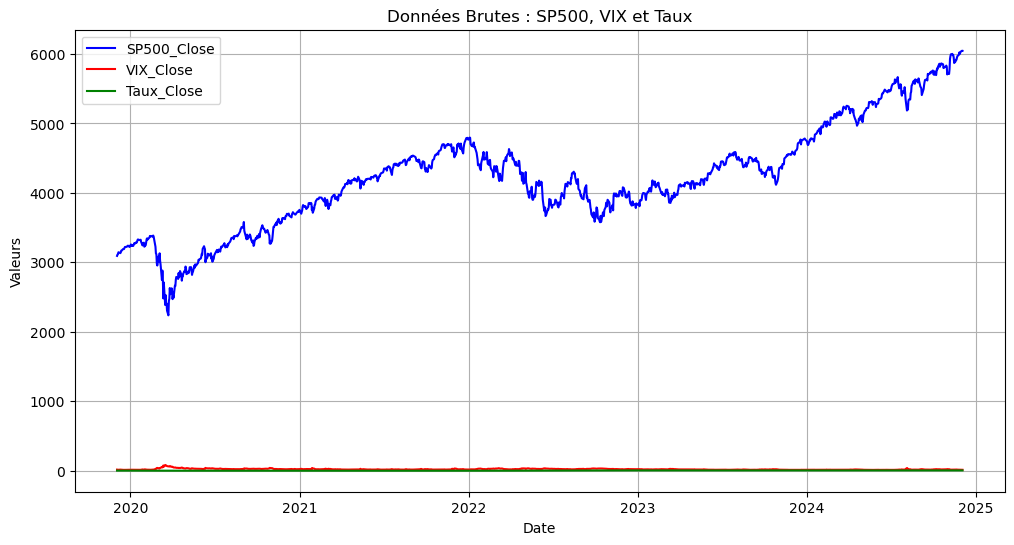

In [10]:
# Graphe 
columns_to_plot = ['SP500_Close', 'VIX_Close', 'Taux_Close']
plt.figure(figsize=(12, 6))
for col, color in zip(columns_to_plot, ['blue', 'red', 'green']):
    plt.plot(merged_data.index, merged_data[col], label=col, color=color)

plt.title("Données Brutes : SP500, VIX et Taux")
plt.xlabel("Date")
plt.ylabel("Valeurs")
plt.legend()  # Affiche la légende pour identifier les séries
plt.grid(True)  # Optionnel : pour améliorer la lisibilité
plt.show()

#### --- Calcul des rendements logarithmiques ---

In [12]:
# Calcul des rendements log pour chaque colonne
log_returns = np.log(merged_data / merged_data.shift(1))

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


#### --- Analyse de stationnarité ---

--- Test ADF pour SP500_Close ---
Statistique ADF : -10.633723728923435
p-value : 5.135778440151262e-19
Valeurs critiques : {'1%': -3.4355964295197743, '5%': -2.863856825923603, '10%': -2.5680035060041626}
Conclusion : La série est stationnaire (p-value ≤ 0.05)
--- Test ADF pour VIX_Close ---
Statistique ADF : -38.826686590469166
p-value : 0.0
Valeurs critiques : {'1%': -3.4355629707955395, '5%': -2.863842063387667, '10%': -2.567995644141416}
Conclusion : La série est stationnaire (p-value ≤ 0.05)
--- Test ADF pour Taux_Close ---
Statistique ADF : -11.767129422745034
p-value : 1.1121338757339898e-21
Valeurs critiques : {'1%': -3.4356175602072545, '5%': -2.8638661490437025, '10%': -2.5680084710921105}
Conclusion : La série est stationnaire (p-value ≤ 0.05)


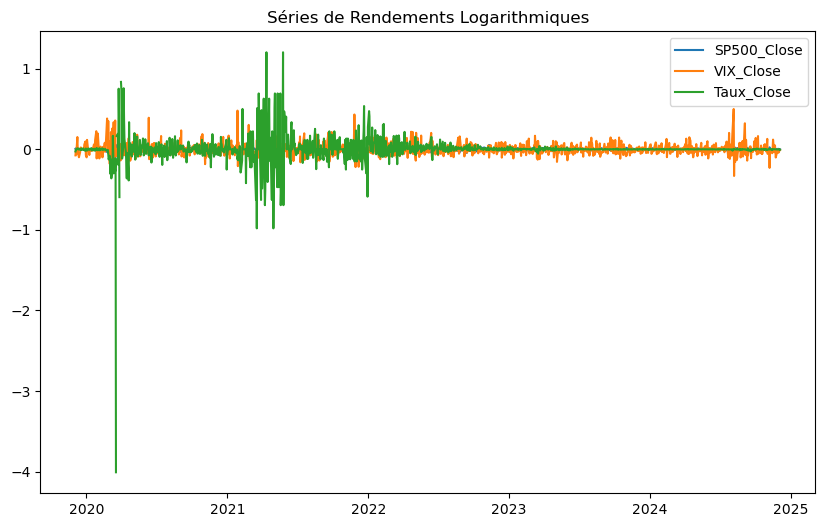

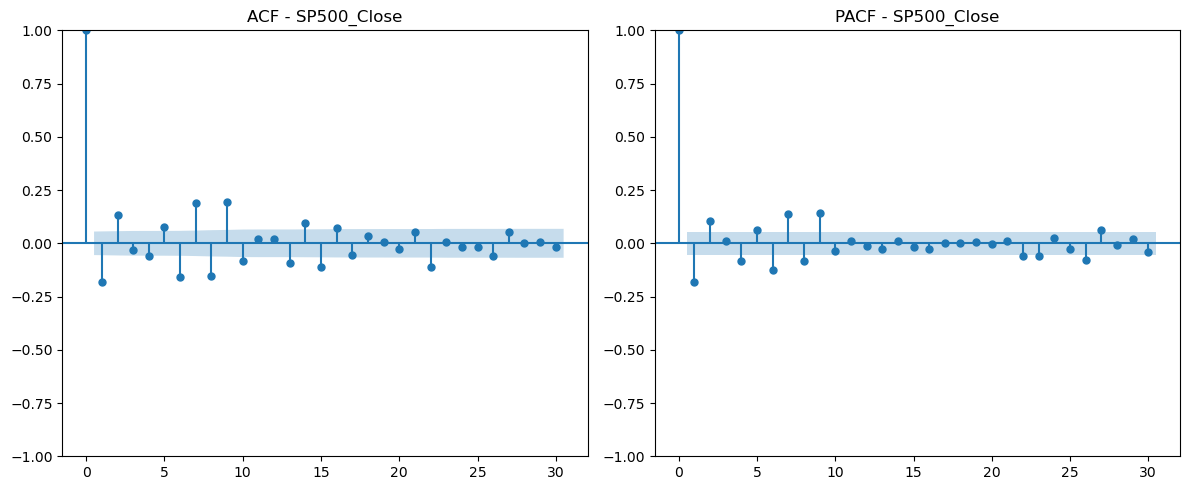

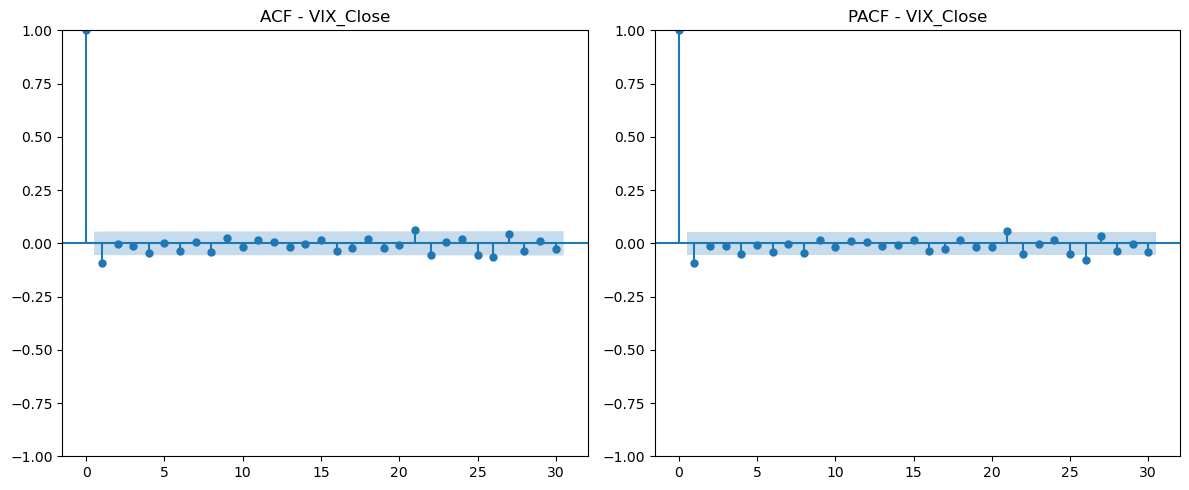

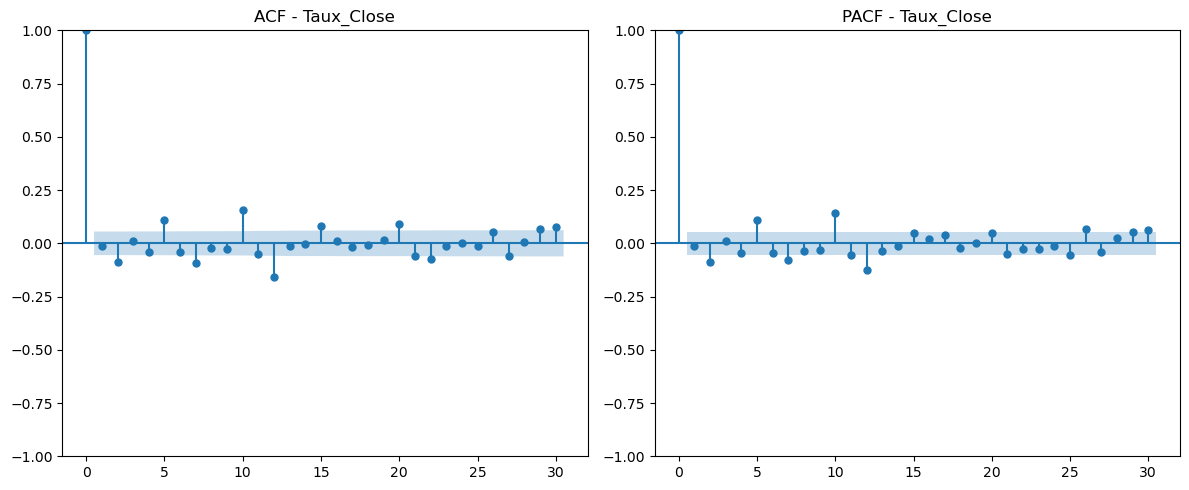

In [14]:
# Fonction pour le test ADF
def adf_test(series, col_name):
    result = adfuller(series.dropna())
    print(f"--- Test ADF pour {col_name} ---")
    print(f"Statistique ADF : {result[0]}")
    print(f"p-value : {result[1]}")
    print(f"Valeurs critiques : {result[4]}")
    if result[1] <= 0.05:
        print("Conclusion : La série est stationnaire (p-value ≤ 0.05)")
    else:
        print("Conclusion : La série n'est pas stationnaire (p-value > 0.05)")

# Appliquer le test ADF sur chaque série
for col in log_returns.columns:
    adf_test(log_returns[col], col)

# --- Visualisation des séries log-return ---
plt.figure(figsize=(10, 6))
for col in log_returns.columns:
    plt.plot(log_returns[col], label=col)
plt.title("Séries de Rendements Logarithmiques")
plt.legend()
plt.show()

# --- Analyse des décalages temporels ---

# Visualisation des lags pour une série
for col in ['SP500_Close', 'VIX_Close', 'Taux_Close']:
    plt.figure(figsize=(12, 5))
    
    # Tracer l'ACF
    plt.subplot(1, 2, 1)
    plot_acf(log_returns[col].dropna(), lags=30, ax=plt.gca())
    plt.title(f"ACF - {col}")
    
    # Tracer la PACF
    plt.subplot(1, 2, 2)
    plot_pacf(log_returns[col].dropna(), lags=30, ax=plt.gca(), method='ywm')
    plt.title(f"PACF - {col}")
    
    plt.tight_layout()
    plt.show()

### <u>3 - Feature engineering</u>

#### --- Calcul des moyennes mobiles (SMA - simple et EMA - exponentielle) ---

In [17]:
merged_data['SMA_20'] = merged_data['SP500_Close'].rolling(window=20).mean()
merged_data['SMA_50'] = merged_data['SP500_Close'].rolling(window=50).mean()
merged_data['EMA_20'] = merged_data['SP500_Close'].ewm(span=20, adjust=False).mean()
merged_data['EMA_50'] = merged_data['SP500_Close'].ewm(span=50, adjust=False).mean()

merged_data = merged_data.dropna(subset=['SMA_20', 'SMA_50'])

#### --- Calcul du RSI ---

In [19]:
def calculate_rsi(data, window=14):
    delta = data.diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

merged_data['RSI_14'] = calculate_rsi(merged_data['SP500_Close'], window=14)

#### --- Calcul du MACD ---

In [21]:
merged_data['EMA_12'] = merged_data['SP500_Close'].ewm(span=12, adjust=False).mean()
merged_data['EMA_26'] = merged_data['SP500_Close'].ewm(span=26, adjust=False).mean()
merged_data['MACD'] = merged_data['EMA_12'] - merged_data['EMA_26']
merged_data['Signal_Line'] = merged_data['MACD'].ewm(span=9, adjust=False).mean()

#### --- Visualisation des indicateurs techniques ---

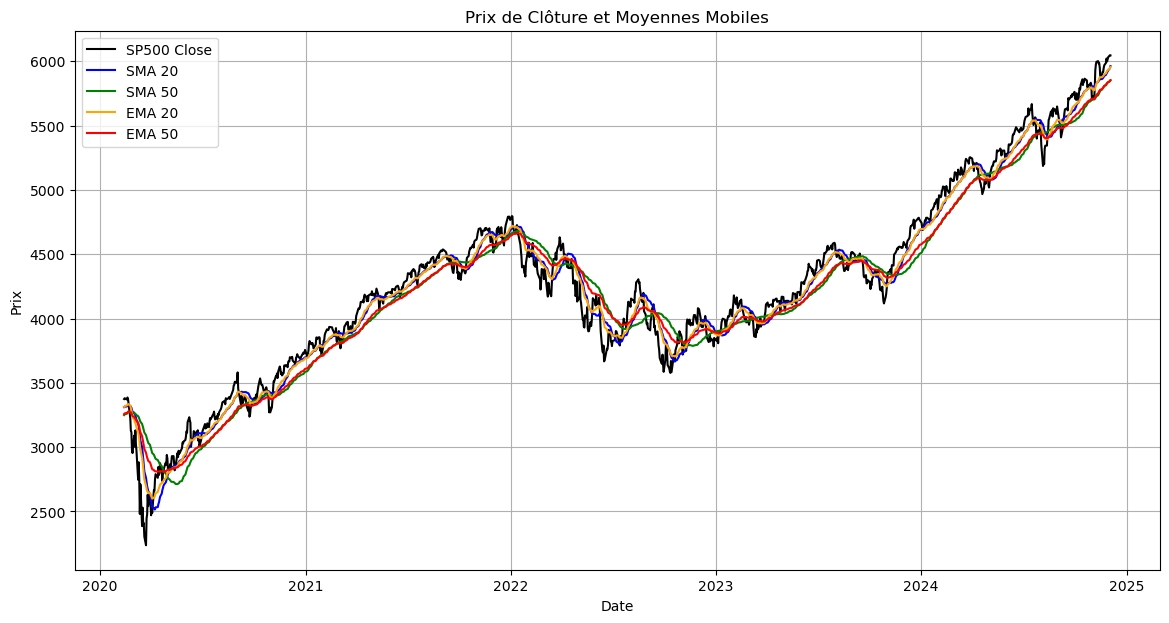

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(merged_data.index, merged_data['SP500_Close'], label='SP500 Close', color='black')
plt.plot(merged_data.index, merged_data['SMA_20'], label='SMA 20', color='blue')
plt.plot(merged_data.index, merged_data['SMA_50'], label='SMA 50', color='green')
plt.plot(merged_data.index, merged_data['EMA_20'], label='EMA 20', color='orange')
plt.plot(merged_data.index, merged_data['EMA_50'], label='EMA 50', color='red')
plt.title('Prix de Clôture et Moyennes Mobiles')
plt.xlabel('Date')
plt.ylabel('Prix')
plt.legend()
plt.grid(True)
plt.show()

#### --- Analyse de la corrélation ---

/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


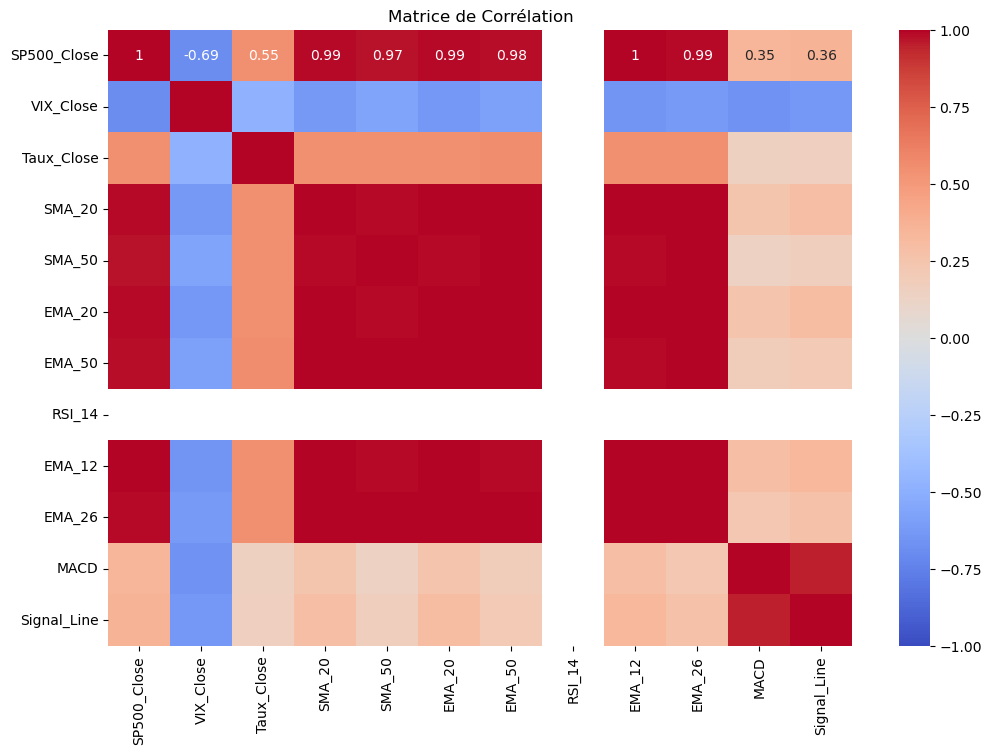

In [25]:
correlation_matrix = merged_data.corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

<h1 style='color: blue;'>Partie 2 : Développement du modèle prédictif</h1>

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### <u>1 - Choix des modèles</u>

#### --- Implémentation régression linéaire ---

In [30]:
# Normalement, 'log_returns' a déjà été défini dans les étapes précédentes
# 'log_returns' doit contenir les rendements logarithmiques calculés

# Définir X (features) et y (target)
X = log_returns.dropna().drop(columns=['SP500_Close'])  # Choisissez les colonnes pertinentes
y = log_returns['SP500_Close'].dropna()

common_indices = X.index.intersection(y.index)
X = X.loc[common_indices]
y = y.loc[common_indices]

# Vérifiez que X et y ont la même taille
print("Longueur de X:", len(X))
print("Longueur de y:", len(y))

# Validation croisée temporelle avec rolling window
n_splits = 5  # Nombre de splits pour la validation croisée
window_size = int(len(X) * 0.8)  # 80% pour l'entraînement

# Initialiser la validation croisée temporelle
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listes pour stocker les résultats
mae_list = []
rmse_list = []
accuracy_list = []

# Pour chaque split dans la validation croisée
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Entraîner le modèle de régression linéaire
    linear_model = LinearRegression()
    linear_model.fit(X_train, y_train)
    
    # Prédictions
    y_pred = linear_model.predict(X_test)
    
    # Calcul des métriques
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Calcul de l'accuracy pour la direction (hausse/baisse)
    y_direction = np.sign(y_test.diff().fillna(0))
    y_pred_direction = np.sign(y_pred - y_test.shift(1)).fillna(0)
    accuracy = accuracy_score(y_direction, y_pred_direction)

    # Stockage des résultats
    mae_list.append(mae)
    rmse_list.append(rmse)
    accuracy_list.append(accuracy)

# Affichage des résultats moyens
print("Régression linéaire - résultats :")
print(f"Moyenne MAE : {np.mean(mae_list)}")
print(f"Moyenne RMSE : {np.mean(rmse_list)}")
print(f"Moyenne Accuracy : {np.mean(accuracy_list)}")

Longueur de X: 1256
Longueur de y: 1256
Régression linéaire - résultats :
Moyenne MAE : 0.005835898765904013
Moyenne RMSE : 0.007833339392096236
Moyenne Accuracy : 0.8478468899521531


#### --- Implémentation Random forest ---

In [32]:
# Définir X (features) et y (target)
X = log_returns.dropna().drop(columns=['SP500_Close'])  # Choisissez les colonnes pertinentes
y = log_returns['SP500_Close'].dropna()

# Assurer que les indices de X et y correspondent
common_indices = X.index.intersection(y.index)
X = X.loc[common_indices]
y = y.loc[common_indices]

# Division des données en train/test (80%/20%)
train_size = int(len(log_returns) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Validation croisée temporelle (rolling window)
n_splits = 5  # Nombre de splits pour la validation croisée
tscv = TimeSeriesSplit(n_splits=n_splits)

# Liste pour stocker les scores des métriques
mae_scores = []
rmse_scores = []
accuracy_scores = []

# Boucle sur les splits de validation croisée
for train_idx, val_idx in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Initialisation du modèle RandomForestRegressor
    model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
    
    # Entraînement du modèle
    model.fit(X_train_fold, y_train_fold)
    
    # Prédictions sur le set de validation
    y_pred = model.predict(X_val_fold)
    
    # Calcul des métriques
    mae = mean_absolute_error(y_val_fold, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
    
    # Calcul de l'accuracy pour la direction (hausse/baisse)
    y_direction = np.sign(y_val_fold.diff().fillna(0))
    y_pred_direction = np.sign(y_pred - y_val_fold.shift(1)).fillna(0)
    accuracy = accuracy_score(y_direction, y_pred_direction)
    
    mae_scores.append(mae)
    rmse_scores.append(rmse)
    accuracy_scores.append(accuracy)

# Moyennes des métriques sur tous les splits
print("Random forest - résultats :")
print(f'Moyenne MAE : {np.mean(mae_scores)}')
print(f'Moyenne RMSE : {np.mean(rmse_scores)}')
print(f'Moyenne Accuracy : {np.mean(accuracy_scores)}')

Random forest - résultats :
Moyenne MAE : 0.007417587395579847
Moyenne RMSE : 0.009831265945269198
Moyenne Accuracy : 0.8407185628742514
